# Phase 1 - Offline Training and Setup

### Data Prep

In [1]:
import pandas as pd
import numpy as np

# Load the multi-batch dataset
df_multi = pd.read_csv("datasets/multi_batch_channels_dataset.csv")
df_context = pd.read_csv("datasets/sla_spc_flowrate_channels_13batches.csv")

# add resin temp, resin age, ambient temp into df_multi
df_multi["resin_temp"] = df_context["resin_temp"]
df_multi["resin_age"] = df_context["resin_age"]
df_multi["ambient_temp"] = df_context["ambient_temp"]

# drop unnessesary columns
df_multi.drop(columns="channel_diameter_mm")

# Compute per-batch mean, std, CV
batch_summary = df_multi.groupby("batch_id")["measured_flow_mL_per_min"].agg(["mean", "std"])
batch_summary["cv"] = batch_summary["std"] / batch_summary["mean"]

print("Batch-level summary:")
print(batch_summary.head())

Batch-level summary:
               mean       std        cv
batch_id                               
BATCH_001  0.373844  0.045291  0.121149
BATCH_002  0.063912  0.003787  0.059255
BATCH_003  6.468637  0.602202  0.093096
BATCH_004  0.273139  0.022820  0.083546
BATCH_005  1.438789  0.159296  0.110715


In [2]:
# Select features (fixed per batch)
knobs = ["resin_type", "layer_thickness_um", "orientation_deg", "support_mode", "fit_adjustment_pct"] # tunable knobs
context = ["resin_age", "resin_temp", "ambient_temp"]  # drift context
print_output = ["channel_length_mm", "channel_width_mm"] # output data from 3d print

features = knobs + context

# Merge batch-level CV back with batch parameters
df_batches = df_multi.groupby("batch_id").first()[features].reset_index()
df_batches = df_batches.merge(batch_summary["cv"].reset_index(), on="batch_id")

print("Prepared dataset:", df_batches.shape)
df_batches.head()

Prepared dataset: (20, 10)


,batch_id,resin_type,layer_thickness_um,orientation_deg,support_mode,fit_adjustment_pct,resin_age,resin_temp,ambient_temp,cv
0,BATCH_001,Resin_C,20,45,manual,0.395,0,76.67,73.85,0.121149
1,BATCH_002,Resin_B,100,45,manual,0.057,0,77.33,70.53,0.059255
2,BATCH_003,Resin_B,50,30,manual,-1.261,0,77.84,72.20,0.093096
3,BATCH_004,Resin_C,20,0,auto,1.948,1,76.51,71.81,0.083546
4,BATCH_005,Resin_A,100,60,manual,-0.901,1,77.06,72.52,0.110715


In [3]:
# Use mean historical CV as baseline
baseline_cv = df_batches["cv"].mean()
print(f"Baseline CV = {baseline_cv:.4f}")

Baseline CV = 0.0907


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

X = df_batches[features] # inputs
y = df_batches["cv"] # targets

categorical = ["resin_type", "support_mode"]
numerical = [f for f in features if f not in categorical]

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical),
    ("num", StandardScaler(), numerical)
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Identify Drift in Historical Data

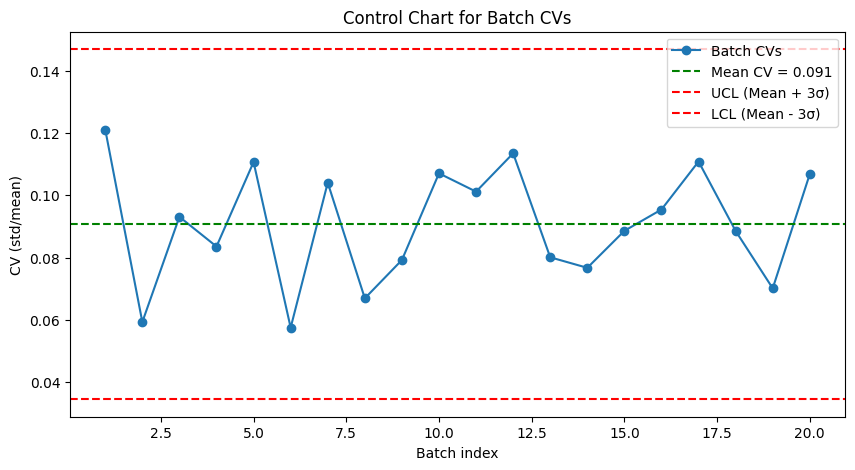

In [5]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10,5))
plt.plot(range(1, len(df_batches)+1), df_batches["cv"], marker="o", linestyle="-", label="Batch CVs")
plt.axhline(df_batches["cv"].mean(), color="green", linestyle="--", label=f"Mean CV = {df_batches['cv'].mean():.3f}")
plt.axhline(df_batches["cv"].mean() + 3*df_batches["cv"].std(), color="red", linestyle="--", label="UCL (Mean + 3σ)")
plt.axhline(df_batches["cv"].mean() - 3*df_batches["cv"].std(), color="red", linestyle="--", label="LCL (Mean - 3σ)")
plt.title("Control Chart for Batch CVs")
plt.xlabel("Batch index")
plt.ylabel("CV (std/mean)")
plt.legend()
plt.show()

#### Relationship between CV and Drift Context (c)

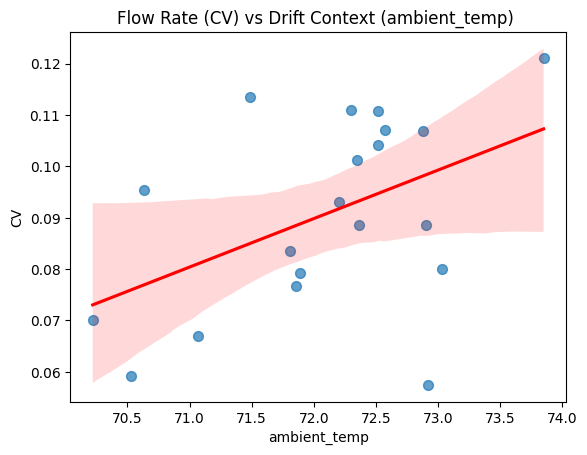

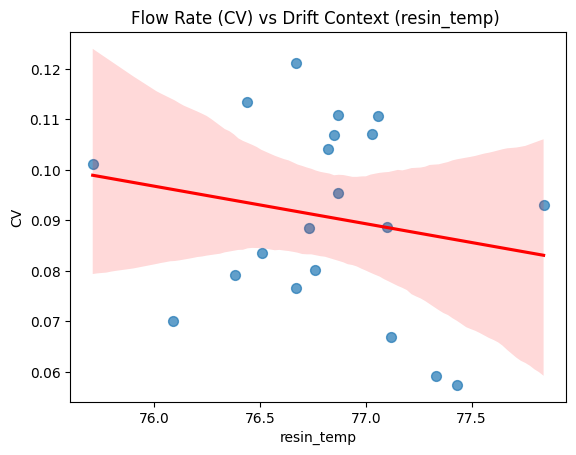

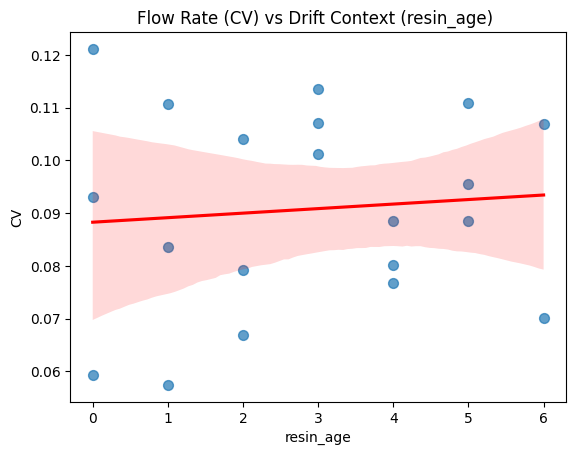

In [6]:
import seaborn as sns

for c in ["ambient_temp", "resin_temp", "resin_age"]:
    sns.regplot(
        x=df_batches[c],
        y=df_batches["cv"],
        scatter_kws={"s": 50, "alpha": 0.7},
        line_kws={"color": "red"},
    )
    plt.title(f"Flow Rate (CV) vs Drift Context ({c}) ")
    plt.xlabel(c)
    plt.ylabel("CV")
    plt.show()


### Train Surrogate Model on Historical Data

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

pipe = Pipeline([
    ("preprocess", preprocess),
    ("rf", RandomForestRegressor(random_state=42))
])

param_grid = {
    "rf__n_estimators": [100, 200, 300, 400, 500],
    "rf__max_depth": [5, 10, 15, 20],
    "rf__max_features": ["sqrt", "log2", None],
}

grid_search = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=5, # num cross-validation folds
    scoring='neg_mean_squared_error', # metric 
    n_jobs=-1,
    verbose=1 # display progress during fitting
)

grid_search.fit(X, y)
print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

best_model = grid_search.best_estimator_

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best parameters found: {'rf__max_depth': 10, 'rf__max_features': None, 'rf__n_estimators': 500}
Best cross-validation score: -0.00030734496721361744


In [8]:
# RF surrogate model
model = best_model

print("Surrogate model R² on test set:", model.score(X_test, y_test))

Surrogate model R² on test set: 0.8414320890802776


### BO Search Space and Current context (c_t)

In [9]:
# BO search space (knobs)
pbounds = {
    "layer_thickness_um": (50, 100), # limited to 50 and 100 per dr. ava's comment
    "orientation_deg": (0, 90),
    "fit_adjustment_pct": (-2.0, 2.0),
    "resin_type": ("Resin_A", "Resin_B", "Resin_C"),
    "support_mode": ("auto", "manual")
}

# current context snapshot BEFORE a print (experimental)
c_t = {
    "ambient_temp": 72,    # °F, lab measurement
    "resin_temp": 76,      # °F, sensor reading
    "resin_age": 12.0,        # days since resin was opened
} 

pre = model.named_steps["preprocess"]
rf  = model.named_steps["rf"]
EXPECTED = list(model.named_steps["preprocess"].feature_names_in_) # list of tunable knobs

In [10]:
# helper functions 
def make_row(x: dict):
    # x contains knobs with strings, e.g. {"resin_type":"Resin_A", ...}
    row = {**c_t, **x}  # merge current context + knobs
    return pd.DataFrame([row], columns=EXPECTED) # EXPECTED from prerpocesser

### Define Objective Function (UCB)
$$UCB\left(x;\lambda\right)=\mu\left(x\right)+\lambda\sigma\left(x\right)$$
- Where
	- $\mu\left(x\right)$ is the **mean predition**; the surrogate model's best guess of the function 
		- **favors exploitation** by selecting points with high predicted performance
	- $\sigma\left(x\right)$ is the **standard deviation**; the surrogate model's uncertainty at that point
		- **favors exploration** by selecting points where uncertainty is large
	- $\lambda$ > 0 is a parameter controlling exploration-exploitation tradeoff
		- larger $\lambda$ -> more exploration 
		- smaller $\lambda$ -> more exploitation

In [11]:
def mu_sigma(df):
    """
    Inputs dataframe of candidates with knobs + context 
    Compute y_pred per tree in forest
    Outputs arrays for mean and std, per row
    """
    Xt = pre.transform(df)
    preds = np.vstack([t.predict(Xt) for t in rf.estimators_])  # [n_trees, n_samples]
    return preds.mean(axis=0), preds.std(axis=0, ddof=1)


def compute_ucb(x, lam=2.0):
    """
    x : dict
        Full input row (knobs + current context).
    lam : float
        Exploration weight λ.
    Returns
    -------
    float : UCB(x; λ)
    """
    import pandas as pd
    X1 = pd.DataFrame([x], columns=EXPECTED)   # enforce schema
    mu, sig = mu_sigma(X1)
    return mu[0] + lam * sig[0]

def objective_ucb(**x):
    row = make_row(x)            # merges knobs and current context
    mu, sig = mu_sigma(row)
    ucb = mu[0] + lam * sig[0]
    return -ucb                   # BO maximizes (equiv to minimizing UCB)

### Define Bayesian Optimization Loop

In [12]:
from bayes_opt import BayesianOptimization

lam = 2.0
optimizer = BayesianOptimization(
    f=objective_ucb,
    pbounds=pbounds,
    random_state=42,
)

optimizer.maximize(init_points=5, n_iter=20)

|   iter    |  target   | layer_... | orient... | fit_ad... | resin_... | suppor... |
-------------------------------------------------------------------------------------
| 1         | -0.108617 | 68.727005 | 85.564287 | 0.9279757 | Resin_A   | auto      |
| 2         | -0.122160 | 57.800932 | 14.039506 | -1.767665 | Resin_A   | manual    |
| 3         | -0.117286 | 57.143340 | 58.579962 | -1.774353 | Resin_B   | manual    |
| 4         | -0.121046 | 50.038938 | 89.299040 | 0.4699260 | Resin_B   | manual    |
| 5         | -0.124924 | 50.353315 | 2.0756182 | 0.0990986 | Resin_C   | manual    |


/tmp/ipykernel_4541/3787005411.py:4: UserWarning: Non-float parameters are experimental and may not work as expected. Exercise caution when using them and please report any issues you encounter.
  optimizer = BayesianOptimization(


| 6         | -0.115628 | 74.618115 | 79.974764 | 1.2524410 | Resin_A   | manual    |
| 7         | -0.108484 | 68.892460 | 84.925483 | 1.3900467 | Resin_A   | auto      |
| 8         | -0.118334 | 62.875278 | 79.332568 | -0.249553 | Resin_B   | manual    |
| 9         | -0.104590 | 73.758480 | 90.0      | 2.0       | Resin_A   | manual    |
| 10        | -0.108505 | 83.496772 | 90.0      | 2.0       | Resin_A   | auto      |
| 11        | -0.127636 | 99.905598 | 89.758269 | 0.6338816 | Resin_C   | manual    |
| 12        | -0.130556 | 99.986014 | 27.984938 | 0.2609790 | Resin_C   | manual    |
| 13        | -0.112199 | 50.014965 | 38.706564 | 1.3204778 | Resin_B   | auto      |
| 14        | -0.103686 | 66.595827 | 40.279031 | 1.9892122 | Resin_A   | auto      |
| 15        | -0.111531 | 74.940052 | 45.482201 | -1.749533 | Resin_A   | auto      |
| 16        | -0.104674 | 69.763206 | 31.250483 | 2.0       | Resin_A   | auto      |
| 17        | -0.113125 | 62.390965 | 34.086728 | -2.0

--- 

# Phase 2 - Online/Closed Loop Optimization

### Closed-Loop Optmization
1. Observe new context
2. Acquire next tunable knobs
3. Execute experiment
4. Update dataset
5. Retrain Surrogate
6. Re-optimize